In [0]:
#Run once per session
import os
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress  --upgrade 
!pip install torch==1.3.1
!pip install torchvision==0.4.2
!pip install Pillow==6.2.1 --upgrade
#os._exit(00)

In [0]:
!pip install git+https://github.com/fastai/fastai2.git
!pip install git+https://github.com/fastai/fastcore.git

# Lesson 6: Keypoint Regression and Object Detection

* Keypoint or **Pose** detection:
* `n` keypoints are found using a CNN where `n` = max number of keypoints present

## Libraries

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

## Data:

For our dataset, we will be working from the Kaggle [Cats](https://www.kaggle.com/crawford/cat-dataset) dataset. Now we are purposefully going to go about cleaning our data beforehand so we understand what it is like

In [0]:
url = "https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM"

In [3]:
!gdown {url}

Downloading...
From: https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM
To: /content/cat-dataset.zip
4.33GB [01:21, 53.3MB/s]


Now that it's downloaded, let's unzip it using `ZipFile`

In [0]:
from zipfile import ZipFile

In [0]:
with ZipFile('cat-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall()

How is the data stored? Let's talk a look by walking on our folders:

In [0]:
import os

In [7]:
[x[0] for x in os.walk('cats')]

['cats',
 'cats/CAT_05',
 'cats/CAT_06',
 'cats/CAT_02',
 'cats/CAT_01',
 'cats/CAT_03',
 'cats/CAT_04',
 'cats/CAT_00']

We have some duplicate folders, let's get rid of the `CAT_` directory and just work out of the `cats` folder

In [0]:
for i in range(7):
  path = Path(f'CAT_0{i}')
  shutil.rmtree(path)

Now we need to move all the files up one level. We can use `pathlib`

In [0]:
for i in range(7):
  paths = Path(f'cats/CAT_0{i}').ls()
  for path in paths:
    p = Path(path).absolute()
    par = p.parents[1]
    p.rename(par/p.name)

How is our data labeled? Our keypoints are available via an image's corresponding `.cat` file. Let's make sure we have an equal number of labels to images

In [0]:
path = Path('cats')

In [0]:
lbls = get_files(path, extensions='.cat')
imgs = get_image_files(path)

In [0]:
test_eq(len(lbls), len(imgs))

We're good to go!

## Visualizing our data

Let's first grab a label based on a file name

In [0]:
def img2kpts(f): return f'{str(f)}.cat'

Let's try this out on an image

In [0]:
fname = imgs[0]

In [0]:
img = PILImage.create(fname)

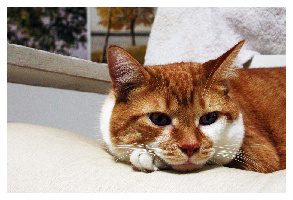

In [35]:
img.show()

Now let's grab some coordinates!

In [36]:
kpts = np.genfromtxt(img2kpts(fname)); kpts

array([  9., 563., 411., 736., 404., 669., 545., 404., 340., 380., 148.,
       528., 261., 739., 254., 869., 123., 811., 325.])

Wait, that's not our keypoints. What is this?

It is, go back to the Kaggle and they describe how it is done. The number of points by default are 9 (the first value in our list):
* Left eye
* Right eye
* Mouth
* Left ear 1
* Left ear 2
* Left ear 3
* Right ear 1
* Right ear 2
* Right ear 3

Now we need to seperate our keypoints into pairs and a `tensor`

In [0]:
def sep_points(coords:array):
  "Seperate a set of points to groups"
  kpts = []
  for i in range(1, int(coords[0]*2), 2):
    kpts.append([coords[i], coords[i+1]])
  return tensor(kpts)

In [37]:
pnts = sep_points(kpts); pnts

tensor([[563., 411.],
        [736., 404.],
        [669., 545.],
        [404., 340.],
        [380., 148.],
        [528., 261.],
        [739., 254.],
        [869., 123.],
        [811., 325.]])

Now let's put it all together. We need to return some `TensorPoints` to have it work in `fastai2`

First let's take what we did above and make a `get_y` function

In [0]:
def get_y(f:Path):
  "Get keypoints for `f` image"
  pts = np.genfromtxt(img2kpts(f))
  return sep_points(pts)

Now there is one more bit of cleaning we need to do, and that is to make sure all my points are within the bounds of my image. But how do I do this?

In [0]:
bad_imgs = []

In [0]:
for name in imgs:
  im = PILImage.create(name)
  y = get_y(name)
  for x in y:
    if x[0] < im.size[0]:
      if x[0] < 0:
        bad_imgs.append(name)

      if x[1] < im.size[1]:
        if x[1] < 0:
          bad_imgs.append(name)
      else:
        bad_imgs.append(name)
    else:
      bad_imgs.append(name)

In [334]:
len(set(bad_imgs))

957

In [0]:
for fname in list(set(bad_imgs)):
  fname.unlink()

Now that we've removed all the bad images, let's continue

Now let's get our `TensorPoints`, just to show an example

In [0]:
def get_ip(img:PILImage, pts:array): return TensorPoint(pts, sz=img.size)

In [337]:
ip = get_y(fname); ip

tensor([[221., 199.],
        [346., 176.],
        [315., 280.],
        [ 79., 172.],
        [ 56.,  55.],
        [162.,  69.],
        [312.,  34.],
        [417., -42.],
        [392., 104.]])

In [0]:
tp = get_ip(img, ip)

Now we can visualize our points. We can pass in an axis to overlay them on top of our image

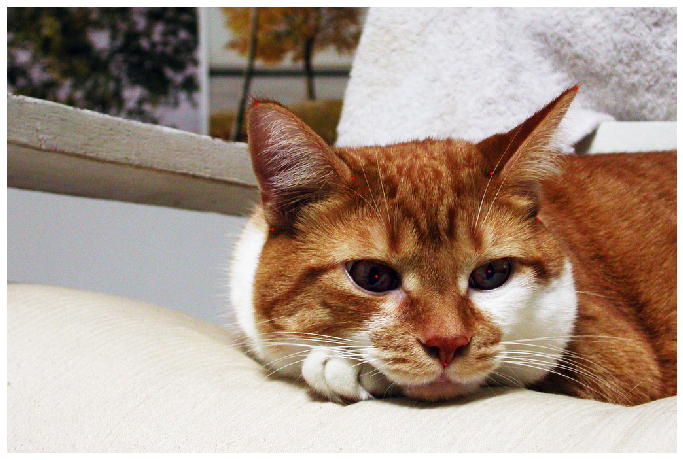

In [40]:
ax = img.show(figsize=(12,12))
tp.show(ctx=ax)

Great, let's datablock it now. We'll keep the transforms very simple for our example problem to just a `Resize`

# DataBlock and Train

In [108]:
Resize(448, method='squish')

Resize: False (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(Image,object) -> encodes 

In [0]:
class ClampPoints(Transform):
  "Clamp points to a minimum and maximum"
  order = 4
  def __init__(self, min=-1, max=1, **kwargs):
    super().__init__(**kwargs)
    self.min, self.max = min, max
  def encodes(self, x:(TensorPoint)):
    for pnt in x:
      cpnt = torch.clamp(x, self.min, self.max)
      for i, t in enumerate(cpnt):
        if any(t==1) or any(t==-1):
          x[i] = tensor([-1,-1])
    return x

In [0]:
item_tfms = [Resize(448, method='squish')]
batch_tfms = [Flip(), Rotate()]

All Keypoint agumentation available:
* Rotate, FlipItem, DihedralItem
* CropPad, RandomCrop, Resize, RandomResizeCrop
* Zoom, Warp

In [0]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

In [0]:
bs=24

With how our `get_y` is, we will want a base path of ''

In [0]:
dls = dblock.dataloaders('', path='', bs=bs)

In [0]:
x1 = []
for x in dls.train_ds:
  for f in dls.train.after_item:
    name = f.name
    x = f(x)
  x1.append(x[1])

In [0]:
max_p = 0
min_p = 0
max_idx = 0
min_idx = 0
for i, pts in enumerate(x1):
  for p in pts:
    if p[0] > max_p:
      max_p = p[0]
      max_idx = i
    if p[1] < min_p:
      min_p = p[1]
      min_idx = i

In [344]:
max_p

tensor(0.9922)

In [345]:
min_p

tensor(-1.)

In [324]:
min_idx

4594

In [327]:
dls.train_ds.items[4594]

Path('cats/00001484_021.jpg')

In [0]:
im = PILImage.create(dls.train_ds.items[4594])

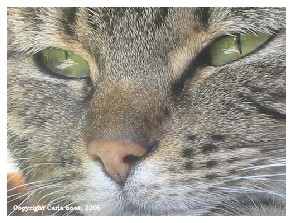

In [329]:
im.show()

In [330]:
im.size

(500, 375)

In [325]:
dls.train_ds[4594]

(<fastai2.vision.core.PILImage image mode=RGB size=500x375 at 0x7FCAB62AC898>,
 TensorPoint([[ 107.,   86.],
         [ 414.,   66.],
         [ 204.,  317.],
         [ -38.,  -24.],
         [   7., -202.],
         [ 140.,  -96.],
         [ 314., -106.],
         [ 410., -233.],
         [ 476.,  -61.]]))

In [0]:
im = dls.train_ds[0][0]

In [0]:
im.na

In [306]:
dls.train_ds[809]

(<fastai2.vision.core.PILImage image mode=RGB size=500x375 at 0x7FCA7F9EF7F0>,
 TensorPoint([[ 107.,   86.],
         [ 414.,   66.],
         [ 204.,  317.],
         [ -38.,  -24.],
         [   7., -202.],
         [ 140.,  -96.],
         [ 314., -106.],
         [ 410., -233.],
         [ 476.,  -61.]]))

In [313]:
dls.train.dataset[809]

(<fastai2.vision.core.PILImage image mode=RGB size=1024x768 at 0x7FCAB6D749B0>,
 TensorPoint([[699., 246.],
         [790., 264.],
         [732., 304.],
         [649., 227.],
         [665., 132.],
         [719., 187.],
         [799., 203.],
         [870., 172.],
         [841., 266.]]))

In [0]:
im = dls.train.dataset[809][0]

In [317]:
im.size

(1024, 768)

In [0]:
tfmd_kpts = torch.cat([x1] for x in dls.train_ds)

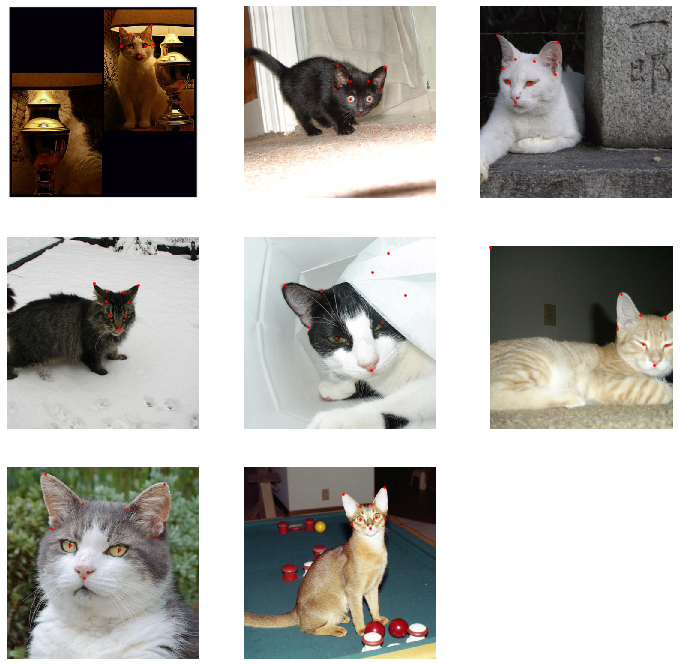

In [275]:
dls.show_batch(max_n=8, figsize=(12,12))

In [0]:
x = dls.train.dataset[809]

In [319]:
for f in dls.train.after_item:
  name = f.name
  x = f(x)
  print(name, x[1])

PointScaler TensorPoint([[ 0.3652, -0.3594],
        [ 0.5430, -0.3125],
        [ 0.4297, -0.2083],
        [ 0.2676, -0.4089],
        [ 0.2988, -0.6562],
        [ 0.4043, -0.5130],
        [ 0.5605, -0.4714],
        [ 0.6992, -0.5521],
        [ 0.6426, -0.3073]])
Resize TensorPoint([[ 0.3652, -0.3594],
        [ 0.5430, -0.3125],
        [ 0.4297, -0.2083],
        [ 0.2676, -0.4089],
        [ 0.2988, -0.6562],
        [ 0.4043, -0.5130],
        [ 0.5605, -0.4714],
        [ 0.6992, -0.5521],
        [ 0.6426, -0.3073]])
ToTensor TensorPoint([[ 0.3652, -0.3594],
        [ 0.5430, -0.3125],
        [ 0.4297, -0.2083],
        [ 0.2676, -0.4089],
        [ 0.2988, -0.6562],
        [ 0.4043, -0.5130],
        [ 0.5605, -0.4714],
        [ 0.6992, -0.5521],
        [ 0.6426, -0.3073]])


In [0]:
ToTensor??

In [0]:
batch = dls.one_batch()

In [225]:
batch[1]

TensorPoint([[[ 0.0825, -0.4688],
         [ 0.1972, -0.4874],
         [ 0.1472, -0.3011],
         [ 0.0202, -0.5715],
         [-0.0306, -0.8422],
         [ 0.0765, -0.6931],
         [ 0.1873, -0.7113],
         [ 0.2478, -0.9131],
         [ 0.2967, -0.6205]],

        [[-0.2141, -0.3762],
         [ 0.0064, -0.5375],
         [-0.0032, -0.2814],
         [-0.3898, -0.4318],
         [-0.6223, -0.6731],
         [-0.3513, -0.6252],
         [-0.1418, -0.7593],
         [-0.9086, -1.0837],
         [ 0.0992, -0.7622]],

        [[-0.1600, -0.2793],
         [ 0.0040, -0.2132],
         [-0.1080, -0.0210],
         [-0.2560, -0.5135],
         [-0.2040, -0.7538],
         [-0.1000, -0.5495],
         [ 0.0400, -0.4895],
         [ 0.2040, -0.6637],
         [ 0.1400, -0.3574]],

        [[-0.2240, -0.0691],
         [ 0.0400,  0.1051],
         [-0.2040,  0.3213],
         [-0.3920, -0.3994],
         [-0.2280, -0.9760],
         [-0.1040, -0.5315],
         [ 0.2040, -0.3153],
   

Great, now let's give it a `.c` attribute so we can create our model's output easier

In [0]:
dls.c = dls.train.after_item.c

In [347]:
dls.c

18

Now let's go through and generate a custom model and head for regression, but how do we do this?

If we know our outputs and inputs, we can make use of two functions, `create_body`, and `create_head`. `create_body` will chop the top of our pre-trained model for us, and `create_head` will make a special `fastai` configured head that has shown to work better. What will we need?

* Outputs: 18 (9 pairs of points)
* Inputs: 1024 filter (2x the last ResNet18 layer)

In [0]:
body = create_body(resnet18, pretrained=True)

In [349]:
body[-1][-1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Now let's make our head

In [350]:
head = create_head(nf=1024, n_out=18); head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=18, bias=False)
)

Finally, we'll wrap them together

In [0]:
arch = nn.Sequential(body, head)

Now we want to utilize transfer learning as best as we can, so we need those discrimitive learning rates. How do we do this? We need to define what this should look like. Here is what it is for our resnet (this is to your discretion based on what you find)

In [0]:
def _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)

In [353]:
arch[1:]

Sequential(
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): full: False
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=18, bias=False)
  )
)

We can see that the `[1:]` grabs the head of our model, and we can safely freeze the body

Lastly we want to initialize our model

In [0]:
apply_init(arch[1], nn.init.kaiming_normal_)

For our loss funciton, we will use `MSELossFlat`

Now that we have all the pieces, let's make a model!

In [0]:
learn = Learner(dls, arch, loss_func=MSELossFlat(), splitter = _resnet_split,
                opt_func=ranger)

In [0]:
learn.freeze()

And let's fit!

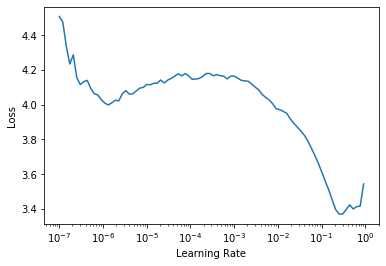

In [359]:
learn.lr_find()

In [360]:
learn.fit_flat_cos(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.155805,0.079843,02:02
1,0.121360,0.075804,02:02
2,0.057329,0.031406,02:02
3,0.029215,0.014585,02:01
4,0.017399,0.010925,02:04


Let's look at some of the initial results

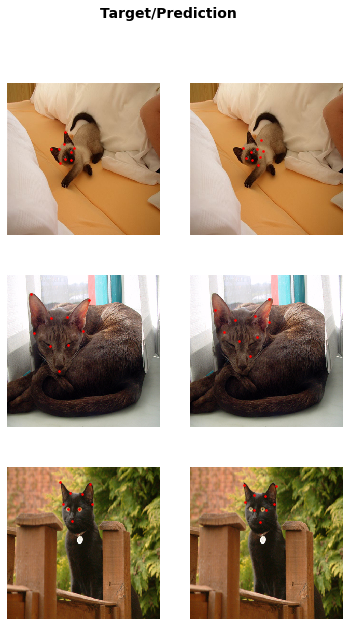

In [363]:
learn.show_results()

Alright, we're getting there! Let's unfreeze and find a new learning rate

In [0]:
learn.unfreeze()

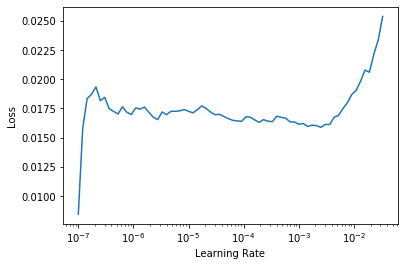

In [365]:
learn.lr_find()

In [366]:
learn.fit_flat_cos(5, 1e-4)

epoch,train_loss,valid_loss,time
0,0.013294,0.008114,02:07
1,0.012472,0.006793,02:06
2,0.010956,0.006156,02:07
3,0.010989,0.005755,02:06
4,0.009330,0.005135,02:06


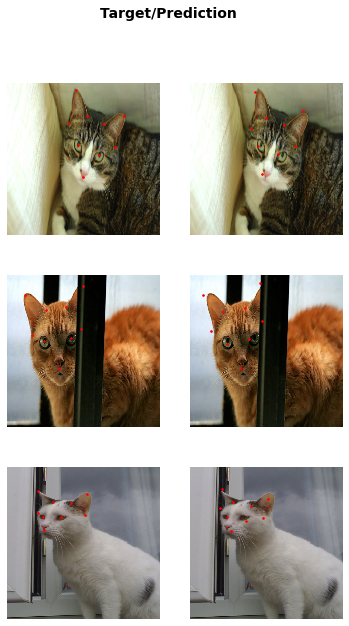

In [367]:
learn.show_results()

Looks much better! And in only ten epochs! (most anything I've seen with this sort of problem in `PyTorch` fits for 100+ epochs)